In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("cleaned_markets.csv")

df.head()

,ticker,event_ticker,market_type,title,subtitle,yes_sub_title,no_sub_title,open_time,close_time,expected_expiration_time,...,category,risk_limit_cents,strike_type,floor_strike,rules_primary,rules_secondary,custom_strike,settlement_value,cap_strike,fee_waiver_expiration_time
0,KXCPICOREYOY-24NOV-T3.4,KXCPICOREYOY-24NOV,binary,Will the rate of core CPI inflation be above 3...,3.4,Above 3.4,Above 3.4,2024-10-24 14:00:00+00:00,2024-12-11 13:25:00+00:00,2024-12-11 15:00:00+00:00,...,NaN,0,greater,3.4,If the Consumer Price Index (CPI) for All Urba...,In the case of a delay in data caused by a fed...,NaN,NaN,NaN,NaN
1,KXCPICOREYOY-24NOV-T3.3,KXCPICOREYOY-24NOV,binary,Will the rate of core CPI inflation be above 3...,3.3,Above 3.3,Above 3.3,2024-10-24 14:00:00+00:00,2024-12-11 13:25:00+00:00,2024-12-11 15:00:00+00:00,...,NaN,0,greater,3.3,If the Consumer Price Index (CPI) for All Urba...,In the case of a delay in data caused by a fed...,NaN,NaN,NaN,NaN
2,KXCPICOREYOY-24NOV-T3.2,KXCPICOREYOY-24NOV,binary,Will the rate of core CPI inflation be above 3...,3.2,Above 3.2,Above 3.2,2024-10-24 14:00:00+00:00,2024-12-11 13:25:00+00:00,2024-12-11 15:00:00+00:00,...,NaN,0,greater,3.2,If the Consumer Price Index (CPI) for All Urba...,In the case of a delay in data caused by a fed...,NaN,NaN,NaN,NaN
3,KXCPICOREYOY-24NOV-T3.1,KXCPICOREYOY-24NOV,binary,Will the rate of core CPI inflation be above 3...,3.1,Above 3.1,Above 3.1,2024-10-24 14:00:00+00:00,2024-12-11 13:25:00+00:00,2024-12-11 15:00:00+00:00,...,NaN,0,greater,3.1,If the Consumer Price Index (CPI) for All Urba...,In the case of a delay in data caused by a fed...,NaN,NaN,NaN,NaN
4,KXCPICOREYOY-24NOV-T3.0,KXCPICOREYOY-24NOV,binary,Will the rate of core CPI inflation be above 3...,3.0,Above 3.0,Above 3.0,2024-10-24 14:00:00+00:00,2024-12-11 13:25:00+00:00,2024-12-11 15:00:00+00:00,...,NaN,0,greater,3.0,If the Consumer Price Index (CPI) for All Urba...,In the case of a delay in data caused by a fed...,NaN,NaN,NaN,NaN


In [13]:
def load(path):
    df = pd.read_csv(path)
    
    datetime_cols = ['open_time', 'close_time', 'expiration_time']
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)
    
    numeric_cols = ['yes_bid', 'yes_ask', 'no_bid', 'no_ask', 
                   'volume', 'open_interest', 'floor_strike']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    df = df.dropna(subset=numeric_cols + ['result'])
    
    return df

In [15]:
def create_features(df):
    try:
        df['days_open'] = (df['close_time'] - df['open_time']).dt.days
        df['hours_to_close'] = (df['expiration_time'] - df['open_time']).dt.total_seconds() / 3600
        df['yes_spread'] = df['yes_ask'].astype(float) - df['yes_bid'].astype(float)
        df['no_spread'] = df['no_ask'].astype(float) - df['no_bid'].astype(float)
        df['imbalance'] = (df['yes_bid'] - df['no_ask']) / (df['yes_ask'] + df['no_bid'] + 1e-6)
        df['strike_pct'] = df['floor_strike'].astype(float) / 100
        
        return df[['days_open', 'hours_to_close', 'yes_spread', 
                 'no_spread', 'imbalance', 'strike_pct', 'volume',
                 'open_interest', 'market_type']]
    except TypeError as e:
        print(f"Type error in feature creation: {e}")
        return None

In [17]:
df = load("cleaned_markets.csv")
X = create_features(df)
X = pd.get_dummies(X, columns=['market_type'])  
y = df['result'].map({'yes': 1, 'no': 0})

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [33]:
preds = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, preds):.2f}")
print(classification_report(y_test, preds))

Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        93
           1       0.97      0.94      0.96       102

    accuracy                           0.95       195
   macro avg       0.95      0.95      0.95       195
weighted avg       0.95      0.95      0.95       195



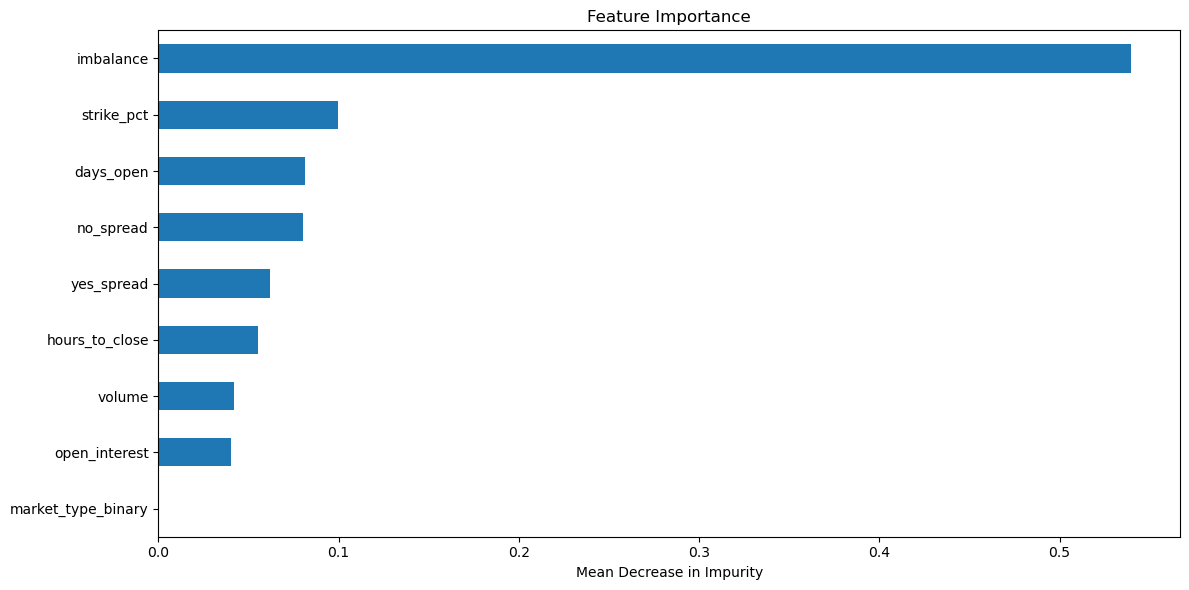

In [35]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay

# 1. Feature Importance Plot
plt.figure(figsize=(12, 6))
pd.Series(model.feature_importances_, index=X.columns).sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.xlabel("Mean Decrease in Impurity")
plt.tight_layout()
plt.show()

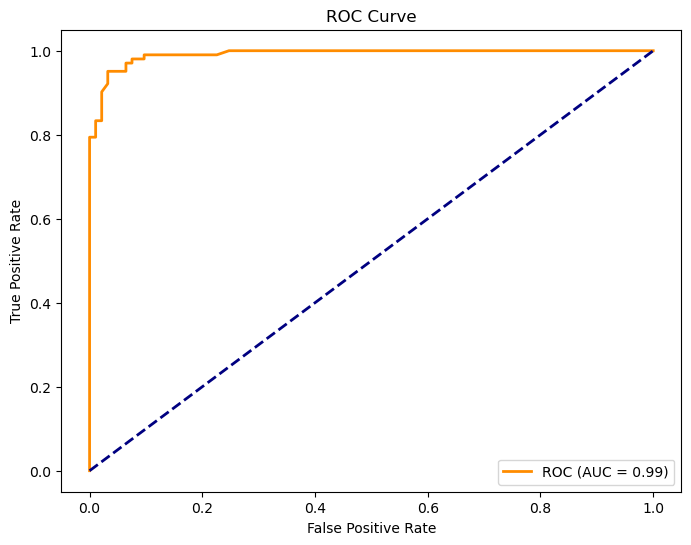

In [37]:
# 2. ROC Curve
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

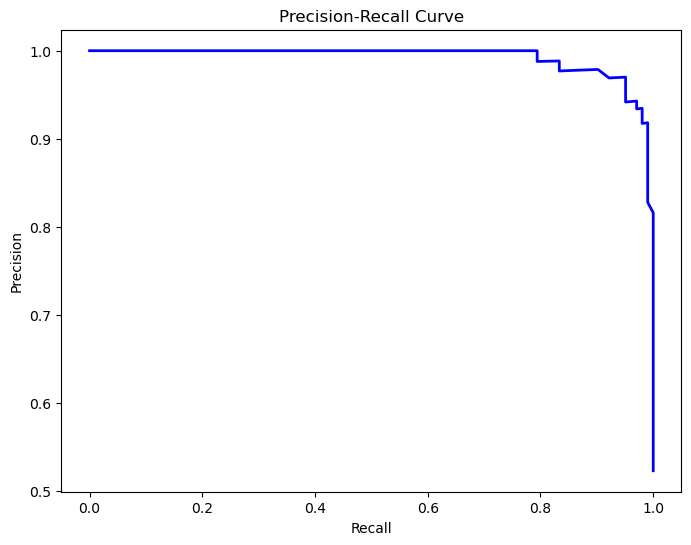

In [39]:
# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

<Figure size 800x600 with 0 Axes>

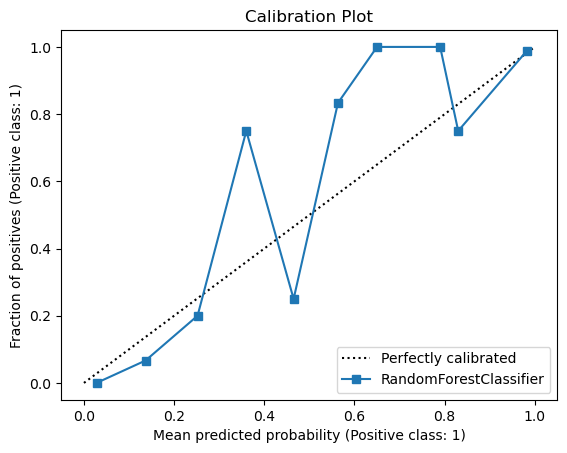

In [41]:
# 4. Calibration Plot
plt.figure(figsize=(8, 6))
CalibrationDisplay.from_estimator(model, X_test, y_test, n_bins=10)
plt.title('Calibration Plot')
plt.show()

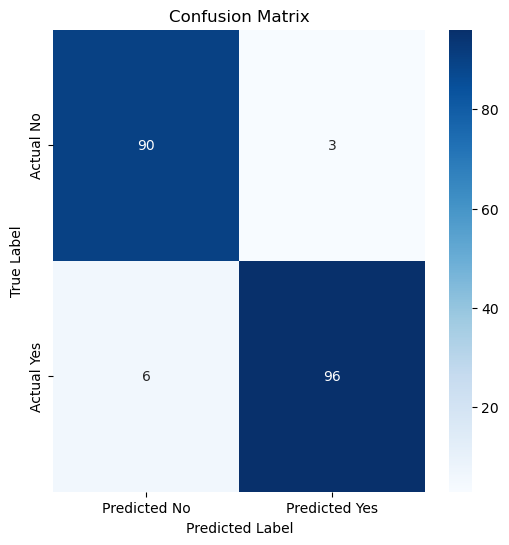

In [43]:
# 5. Confusion Matrix Heatmap
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

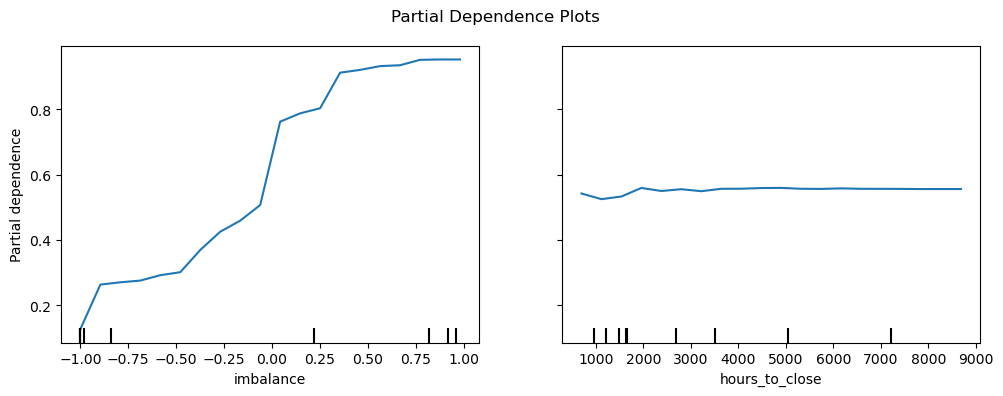

In [45]:
# 6. Partial Dependence Plots
fig, ax = plt.subplots(figsize=(10, 4))
PartialDependenceDisplay.from_estimator(
    model, X, features=['imbalance', 'hours_to_close'], 
    grid_resolution=20, ax=ax
)
plt.suptitle('Partial Dependence Plots')
plt.tight_layout()
plt.show()